In [1]:
#INSTALL LIBRARIES------------------------------------------
!pip install transformers scikit-learn datasets wandb word2number nltk torch_geometric
!pip install --upgrade ipykernel
!git clone https://github.com/monteleone-1883922/hw2_nlp.git
%cd hw2_nlp/
!git checkout huggingFaceBase
%cd ..
!cp hw2_nlp/manipulations.py .
!cp hw2_nlp/augmentation.py .
!rm -r hw2_nlp/

Cloning into 'hw2_nlp'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 307 (delta 95), reused 55 (delta 26), pack-reused 159 (from 1)
Receiving objects: 100% (307/307), 1.17 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/hw2_nlp
Branch 'huggingFaceBase' set up to track remote branch 'huggingFaceBase' from 'origin'.
Switched to a new branch 'huggingFaceBase'
/content


In [2]:
#IMPORTS-----------------------------
from pprint import pprint
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from torch.nn import Linear, ReLU
import pdb
import numpy as np, torch, random as rnd, torch.nn as nn, wandb
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import sys, os, json
from transformers import AutoModelForQuestionAnswering
from torch.nn.functional import cosine_similarity
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import os, time
from augmentation import augment_data, augment_data_multithread
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn.norm import BatchNorm
import torch.nn.init as init


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:


# adversarial = load_dataset("iperbole/adversarial_fever_nli")["test"]

# ds = load_dataset("tommasobonomo/sem_augmented_fever_nli")

# training_set = ds["train"]

# validation_set = ds["validation"]

# test_set = ds["test"]




In [4]:
# random.seed(42)

# training_set, new_data, info_augmentations = augment_data(training_set, 2000)

In [5]:
# grouped_data = {}
# for sample in new_data:
#     augment_value = sample['augment_method']
#     grouped_data[augment_value] = grouped_data.get(augment_value, []) + [sample]
# pprint(info_augmentations)

# total_attempts = 0
# total_successes = 0

# # Itera attraverso il dizionario e somma i valori
# for key, values in info_augmentations.items():
#     total_attempts += values['count']
#     total_successes += values['success']

# # Stampa i risultati
# print(f"Totale tentativi: {total_attempts}")
# print(f"Totale successi: {total_successes}")

In [6]:
# pprint(grouped_data['CHANGE_NUMBERS'][3])

# NEGATE_PART_PREMISE = 1
#     # anything -> same thing
#     SYNONYM = 2
#     # anything -> negation
#     ANTINOMY_PART_PREMISE = 3
#     # anything -> same thing
#     HYPONYM_PREMISE = 4
#     # anything -> neutral
#     SWITCH_DATA = 5
#     # anything -> neutral
#     SWITCH_PARTIAL_DATA = 6
#     # anything -> entailment
#     TAKE_PART_PREMISE = 7
#     # entailment/negation -> opposite
#     NEGATE_HYPOTHESIS = 8
#     # anything -> same thing
#     HYPERNYM_HYPOTHESIS = 9
#     # anything -> negation
#     IMPOSSIBILITY = 10
#     # entailment -> entailment
#     TRUNCATE_HYPOTHESIS = 11
#     # anything -> entailment
#     TAUTOLOGY = 12
#     # anything -> entailment
#     DUPLICATE_HYPOTHESIS = 13
#     # entailment -> negation/entailment
#     CHANGE_NUMBERS = 14


In [7]:
# print(training_set[0]['hypothesis'])
# print(training_set[0]['premise'])
# print(training_set[1]['hypothesis'])
# print(training_set[1]['premise'])
# print(training_set[2]['hypothesis'])
# print(training_set[2]['premise'])

In [8]:

# import nltk
# from nltk.corpus import stopwords

# nltk.download('stopwords')
# print(stopwords.words('english'))



In [9]:
# f1 = "test per vedere come va"
# f2 = "questa è una prova"

# tokenized = tokenizer(f1+ tokenizer.eos_token + f2, return_tensors='pt', padding='max_length', max_length=40, return_token_type_ids=True)

# print(tokenized)
# print(tokenized["input_ids"].shape)
# print(type(tokenized))

# out = model(**tokenized)
# print(out['last_hidden_state'].shape)

# print(out.last_hidden_state.mean(dim=-1).squeeze().shape)

In [10]:
# Function to print a progress bar
def print_progress_bar(percentuale: float, lunghezza_barra: int = 30, text: str="") -> None:
    blocchi_compilati = int(lunghezza_barra * percentuale)
    barra = "[" + "=" * (blocchi_compilati - 1) + ">" + " " * (lunghezza_barra - blocchi_compilati) + "]"
    sys.stdout.write(f"\r{barra} {percentuale * 100:.2f}% complete " + text)
    sys.stdout.flush()

In [11]:
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('punkt')


class NLIDataset(Dataset):

    def __init__(self, data, file_name='',load = False, adversarial=False, do_remove_stopwords=False,
                 do_remove_punctuation=False, do_use_similarities=False, base_set=True, do_lemmatization=False):
        self.sentence_info = None
        self.labels = None
        self.sentences = None
        self.load = load
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.encode_labels = {'CONTRADICTION': 0, 'NEUTRAL': 1, 'ENTAILMENT': 2}
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.model = RobertaModel.from_pretrained('roberta-base').to(self.device)
        self.distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
        self.file_name = file_name
        self.do_use_similarities = do_use_similarities
        self.do_lemmatization = do_lemmatization
        self.do_remove_punctuation = do_remove_punctuation
        self.base_set = base_set
        self.do_remove_stopwords = do_remove_stopwords
        self.adversarial = adversarial
        self.organize_data(data)
        self.tokenizer = None
        self.model = None
        self.count = 0

    def organize_data(self, data):
        info_samples = []
        sentences = []
        labels = []
        premise_hypotesis = []
        if not self.load or not os.path.isfile(self.file_name):
            for num_sample, sample in enumerate(data):
                print_progress_bar(num_sample / len(data), text=" | loading data")
                #breakpoint()
                labels.append(self.encode_labels[sample["label"]])
                premise_hypotesis.append(sample['premise'] + " [SEP] " + sample['hypothesis'])
                sentence = []
                list_sentence_premise = [token["rawText"] for token in sample['srl']['premise']['tokens']]
                list_sentence_hypothesis = [token["rawText"] for token in sample['srl']['hypothesis']['tokens']]
                info_sample = {"ids_verbs": [], "edges": []}
                idx = 0
                edge_idx = 0
                verb_edge_idx = -1
                repeated_nodes = {}
                # premise -----------------------------
                for annotation in sample['srl']['premise']['annotations']:
                    if verb_edge_idx != -1:
                        info_sample["edges"].append((verb_edge_idx, edge_idx))
                        info_sample["edges"].append((edge_idx, verb_edge_idx))
                    verb_edge_idx = edge_idx
                    edge_idx += 1
                    verb_word_only = True
                    if len(sample['wsd']['premise']) > annotation['tokenIndex'] and sample['wsd']['premise'][annotation['tokenIndex']]['nltkSynset'] != 'O' and sample['wsd']['premise'][annotation['tokenIndex']]['pos'] == 'VERB':
                        examples = wn.synset(sample['wsd']['premise'][annotation['tokenIndex']]['nltkSynset']).examples()
                        id_verb = []
                        for example in examples:
                            if example != '':
                                id_verb.append(idx)
                                idx += 1
                                verb_word_only = False
                                sentence.append( example + ' [SEP] ')
                        info_sample["ids_verbs"].append(tuple(id_verb))
                    if verb_word_only:
                        info_sample["ids_verbs"].append((idx,))
                        idx += 1
                        sentence.append(list_sentence_premise[annotation['tokenIndex']] + ' [SEP] ')
                    for element in annotation['verbatlas']['roles']:
                        if element['span']:
                            if (element['span'][0], element['span'][1]) in repeated_nodes:
                                info_sample["edges"].append((repeated_nodes[(element['span'][0], element['span'][1])], verb_edge_idx))
                                info_sample["edges"].append((verb_edge_idx, repeated_nodes[(element['span'][0], element['span'][1])]))
                            else:
                                info_sample["edges"].append((verb_edge_idx, edge_idx))
                                info_sample["edges"].append((edge_idx, verb_edge_idx))
                                edge_idx += 1
                                idx += 1
                                sentence.append(' '.join(list_sentence_premise[element['span'][0]:element['span'][1]]) + ' [SEP] ')
                                repeated_nodes[(element['span'][0], element['span'][1])] = edge_idx
                repeated_nodes.clear()
                verb_edge_idx = -1
                # hypothesis -----------------------------
                for annotation in sample['srl']['hypothesis']['annotations']:
                    if verb_edge_idx != -1:
                        info_sample["edges"].append((verb_edge_idx, edge_idx))
                        info_sample["edges"].append((edge_idx, verb_edge_idx))
                    verb_edge_idx = edge_idx
                    edge_idx += 1
                    verb_word_only = True
                    if len(sample['wsd']['hypothesis']) > annotation['tokenIndex'] and sample['wsd']['hypothesis'][annotation['tokenIndex']]['nltkSynset'] != 'O' and sample['wsd']['hypothesis'][annotation['tokenIndex']]['pos'] == 'VERB':
                        examples = wn.synset(sample['wsd']['hypothesis'][annotation['tokenIndex']]['nltkSynset']).examples()
                        id_verb = []
                        for example in examples:
                            if example != '':
                                id_verb.append(idx)
                                idx += 1
                                verb_word_only = False
                                sentence.append(example + ' [SEP] ')
                        info_sample["ids_verbs"].append(tuple(id_verb))
                    if verb_word_only:
                        info_sample["ids_verbs"].append((idx,))
                        idx += 1
                        sentence.append(list_sentence_hypothesis[annotation['tokenIndex']] + ' [SEP] ')
                    for element in annotation['verbatlas']['roles']:
                        if element['span']:
                            if (element['span'][0], element['span'][1]) in repeated_nodes:
                                info_sample["edges"].append(
                                    (repeated_nodes[(element['span'][0], element['span'][1])], verb_edge_idx))
                                info_sample["edges"].append(
                                    (verb_edge_idx, repeated_nodes[(element['span'][0], element['span'][1])]))
                            else:
                                info_sample["edges"].append((verb_edge_idx, edge_idx))
                                info_sample["edges"].append((edge_idx, verb_edge_idx))
                                edge_idx += 1
                                idx += 1
                                sentence.append(' '.join(list_sentence_premise[element['span'][0]:element['span'][1]]) + ' [SEP] ')
                                repeated_nodes[(element['span'][0], element['span'][1])] = edge_idx
                info_sample["num_nodes"] = edge_idx
                info_sample["num_sentences"] = idx
                sentences.append(' '.join(sentence))
                info_samples.append(info_sample)
            if self.file_name != '':
                with open(self.file_name, 'w') as file:
                    json.dump({'sentences': sentences, 'info_samples': info_samples, 'labels': labels, 'premise_hypotesis': premise_hypotesis}, file)
        else:
            with open(self.file_name, 'r') as file:
                loaded_data = json.load(file)
            sentences = loaded_data['sentences']
            info_samples = loaded_data['info_samples']
            labels = loaded_data['labels']
            premise_hypotesis = loaded_data['premise_hypotesis']

        self.sentences = sentences
        self.sentence_info = info_samples
        self.labels = labels
        self.premise_hypotesis = premise_hypotesis

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx], self.sentence_info[idx], self.premise_hypotesis[idx]

    def get_deleted_per_epoch(self, num_epochs):
        out = self.count / num_epochs
        self.count = 0
        return out

    def collate(self, batch):
        #breakpoint()
        inputs = []
        gold_outputs = []
        edges = []
        verb_ids = []
        offset_edges = 0
        offset_sentences = 0
        num_nodes = []
        classic_inputs = []
        for input_batch, gold_outputs_batch, sample_info_batch, premise_hypotesis in batch:
            if len(word_tokenize(input_batch)) < 500:
                inputs.append(input_batch)
                gold_outputs.append(gold_outputs_batch)
                classic_inputs.append(premise_hypotesis)
                edges.extend([(x + offset_edges, y + offset_edges) for x, y in sample_info_batch["edges"]])

                # Convertiamo da tuple a liste

                offset_edges += sample_info_batch["num_nodes"]


                verb_ids.append(sample_info_batch["ids_verbs"])
                offset_sentences += sample_info_batch["num_sentences"]
            else:
                self.count += 1
        #breakpoint()
        inputs = self.distilbert_tokenizer(
            inputs,
            max_length=512,
            return_offsets_mapping=True,
            padding="max_length",
            return_tensors="pt"
        )
        classic_inputs = self.distilbert_tokenizer(
            classic_inputs,
            max_length=512,
            return_offsets_mapping=True,
            padding="max_length",
            return_tensors="pt"
        )


        gold_outputs = torch.tensor(gold_outputs, dtype=torch.long)
        edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

        return inputs['input_ids'].to(self.device), inputs['attention_mask'].to(self.device), gold_outputs.to(self.device), \
            edges.to(self.device), verb_ids, classic_inputs.to(self.device)






    def get_dataloader(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=True, collate_fn=self.collate)


# prompt: create a torch model using roberta and a linear layer

class RobertaClassifier(nn.Module):
    def __init__(self, use_similarity, num_labels=3, dropout=0):
        super(RobertaClassifier, self).__init__()
        self.distilbert = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.gnn = GATv2Conv(self.distilbert.config.hidden_size, 64, dropout=0.3)
        # self.gnn1 = GATConv(64, 64)
        self.gnn2 = GATv2Conv(64, 32, dropout=0.15)  # ,heads=2)
        self.linear = nn.Linear(self.distilbert.config.hidden_size + 32, 64)
        #self.linear2 = nn.Linear(128, 128)
        self.classifier = nn.Linear(64, 3)
        self.initialize_weights()
        self.relu = nn.LeakyReLU()
        self.batchnorm_linear = nn.BatchNorm1d(64)
        # self.batchnorm_gnn = BatchNorm(64)  # Modifica con hidden_size corretto
        # self.batchnorm_gnn2 = BatchNorm(32)
        self.special_token = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased").sep_token_id

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, GATv2Conv):
                # Inizializzazione dei pesi per GATConv
                init.kaiming_normal_(layer.lin_l.weight, a=0.01)

                if layer.lin_l.bias is not None:
                    init.zeros_(layer.lin_l.bias)


                # Se hai anche la parte destra del layer di attenzione
                if hasattr(layer, 'lin_r') and layer.lin_r is not None:
                    init.kaiming_normal_(layer.lin_r.weight, a=0.01)  # destra
                    if layer.lin_r.bias is not None:
                        init.zeros_(layer.lin_r.bias)

            elif isinstance(layer, nn.Linear):
                # Inizializzazione Xavier per i layer lineari
                init.kaiming_normal_(layer.weight, a=0.01)

                if layer.bias is not None:
                    init.zeros_(layer.bias)

    # def extract_next_verb(verb_ids, verb_idx, k, range_sep):
    #     new_k = -1
    #     for i in range(verb_idx, len(verb_ids)):
    #         out_of_range = False
    #         for j in range(k, len(verb_ids[verb_idx])):
    #             if verb_ids[i][j].item() >= range_sep:
    #                 out_of_range = True
    #                 new_k = j
    #                 break
    #         k = 0
    #         if not out_of_range:
    #             return i, new_k, verb_ids[i][0].item()
    #     return -1,-1,-1


    def freeze(self, epoch):
        if epoch == 1:
            freeze_until_layer = 99999
        else:
            freeze_until_layer = None  # Non congela nulla

        # Congela i layer di DistilBERT
        if freeze_until_layer is not None:
            for idx, param in enumerate(self.distilbert.parameters()):
                if idx < freeze_until_layer:
                    param.requires_grad = False
                else:
                    param.requires_grad = True

    def forward(self, input_ids, attention_mask, edges, verb_ids, classic_inputs):
        #breakpoint()
        inputs = torch.cat((input_ids, classic_inputs['input_ids']), dim=0)
        attention_mask = torch.cat((attention_mask, classic_inputs['attention_mask']), dim=0)

        outputs = self.distilbert(input_ids=inputs, attention_mask=attention_mask)
        embeddings, output2 = torch.split(outputs.last_hidden_state, input_ids.size(0), dim=0)
        verb_idx = 0
        nodes, node_counts = [], []
        #breakpoint()
        for i, sample_input_ids in enumerate(input_ids):

            sample_embeddings = embeddings[i]
              # [sequence_length, hidden_size]
            sep_positions = (sample_input_ids == self.special_token).nonzero(as_tuple=True)[0] # Posizioni dei [SEP]


            # Suddividi gli embedding basandoti sulle posizioni dei [SEP]
            start, num_nodes, verb_embedding = 0, 0, []
            k, next_verb = 0, verb_ids[verb_idx][0] if 0 < len(verb_ids[verb_idx]) else -1
            for j, sep_pos in enumerate(sep_positions):
                if sep_pos != start:
                    frase_embedding = sample_embeddings[start:sep_pos].mean(dim=0)
                    if j == next_verb:
                        verb_embedding.append(frase_embedding)
                        if k + 1 >= len(verb_ids[verb_idx]):
                            nodes.append(torch.stack(verb_embedding).mean(dim=0))#nodes.append(torch.tensor(verb_embedding).mean(dim=0))
                            num_nodes += 1
                            verb_embedding, k = [], 0
                            verb_idx += 1
                        else:
                            k += 1
                        next_verb = verb_ids[verb_idx][k]
                    else:
                        nodes.append(frase_embedding)
                        num_nodes += 1
                    start = sep_pos + 1
            node_counts.append(num_nodes)

        #breakpoint()
        x = self.gnn(torch.stack(nodes), edges)
        # x = self.batchnorm_gnn(x)
        x = self.relu(x)
        x = self.dropout(x)
        # x = self.gnn1(x, edges)
        # x = self.relu(x)
        # x = self.dropout(x)
        x = self.gnn2(x, edges)

        pooled_embeddings = []

        # Indice iniziale per fare slicing sugli embedding
        start_idx = 0
        #breakpoint()
        # Scorri sulla lista di node_counts
        for num_nodes in node_counts:
            # Prendi gli embedding dei nodi per la frase corrente
            current_nodes = x[start_idx:start_idx + num_nodes]

            # Aggiungi l'embedding medio alla lista
            pooled_embeddings.append(current_nodes.mean(dim=0))

            # Aggiorna l'indice iniziale per la frase successiva
            start_idx += num_nodes
        #breakpoint()

        # Concatena gli embedding medi per ottenere un tensore 2D di dimensione (batch_size, hidden_size)
        pooled_embeddings = torch.stack(pooled_embeddings)

        pooled_embeddings = torch.cat((pooled_embeddings, output2[:, 0, :]), dim=1)

        to_classify = self.relu(self.batchnorm_linear(self.linear(pooled_embeddings)))
        # to_classify = self.dropout(to_classify)
        # to_classify = self.relu(self.linear2(to_classify))
        to_classify = self.dropout(to_classify)

        out = self.classifier(to_classify)

        return out



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:


class Trainer():

    def __init__(self, model,train_dataloader, validation_dataloader, optimizer, loss_function, device, scheduler=None):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.validation_dataloader = validation_dataloader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.scheduler = scheduler


    @staticmethod
    def evaluation_parameters(y_true, y_pred):
        #breakpoint()
        y_pred = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        accuracy = accuracy_score(y_true, y_pred)
        return cm, precision, recall, f1, accuracy

    @staticmethod
    def format_time_delay(seconds):
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60
        return hours, minutes, seconds


    def train(self, epochs: int, use_wandb: bool = False, config: dict = {}, name: str="", target_f1: float=0.0):
        start_time = time.time()
        best_model = None
        old_name = ''
        if use_wandb:
            wandb.init(
                # Set the project where this run will be logged
                project="nlphw2",
                name=name,
                # Track hyperparameters and run metadata
                config=config
            )
        validation_loss, precision, recall, f1, accuracy, cm = self.validate(use_wandb)
        total_loss = validation_loss
        if use_wandb:
                wandb.log({"validation_loss": validation_loss,
                      "precision": precision,
                      "recall": recall,
                      "f1": f1,
                      "accuracy": accuracy,
                      "train_loss": total_loss / len(self.train_dataloader)})
        for epoch in range(epochs):

            time_delay = time.time() - start_time
            hours, minutes, seconds = self.format_time_delay(time_delay)
            print(f"\nTempo trascorso: {hours} ore, {minutes} minuti, {seconds} secondi")
            self.model.freeze(epoch)
            self.model.train()  # Set the model to training mode
            total_loss = 0
            #breakpoint()
            for i, batch in enumerate(self.train_dataloader):
                print_progress_bar(i / len(self.train_dataloader), text=f" | training epoch {epoch}")
                # Get the inputs and targets from the batch
                inputs, mask, targets, edges, verbs, classic_inputs = batch

                # Zero the gradients
                self.optimizer.zero_grad()
                # Forward pass
                outputs = self.model(inputs, mask,  edges, verbs, classic_inputs)
                #print("outputs = ", outputs,"\ntargets = ", targets)
                #breakpoint()
                # Compute loss
                loss = self.loss_function(outputs, targets)
                #print(loss)
                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()
                # Accumulate the total loss
                total_loss += loss.item()

            # Print the average loss for this epoch
            validation_loss, precision, recall, f1, accuracy, cm = self.validate(use_wandb)
            if f1 > target_f1:
                best_model = self.model.state_dict()
                target_f1 = f1
                if old_name != '':
                    os.remove(old_name)
                old_name = name + f'-{target_f1}.pth'
                torch.save(best_model, name + f'-{target_f1}.pth')
            if use_wandb:
                wandb.log({"validation_loss": validation_loss,
                      "precision": precision,
                      "recall": recall,
                      "f1": f1,
                      "accuracy": accuracy,
                      "train_loss": total_loss / len(self.train_dataloader)})
            if self.scheduler is not None:
                self.scheduler.step()
        print('\nbest f1: ', target_f1)
        if use_wandb:
            wandb.finish()



    def validate(self, use_wandb: bool = False, test_dataloader=None, load_from=''):
        if os.path.isfile(load_from):
            self.model.load_state_dict(torch.load(load_from, map_location=torch.device('cpu')))
        dataloader = self.validation_dataloader if test_dataloader is None else test_dataloader
        if dataloader is None:
            print("empty dataloader!")
            exit(1)
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0
        all_predictions = torch.tensor([])
        all_targets = torch.tensor([])
        with torch.no_grad():  # Do not calculate gradients
            for i, batch in enumerate(dataloader):
                print_progress_bar(i / len(dataloader), text=" | validation")
                # Get the inputs and targets from the batch
                inputs, mask, targets,  edges, verbs, classic_inputs  = batch

                # Forward pass
                #breakpoint()
                outputs = self.model(inputs, mask,  edges, verbs, classic_inputs)
                # Compute loss
                #breakpoint()
                loss = self.loss_function(outputs, targets)
                # Accumulate the total loss
                total_loss += loss.item()
                # Store predictions and targets
                all_predictions = torch.cat((all_predictions, outputs.squeeze().round().cpu()))
                all_targets = torch.cat((all_targets, targets.cpu()))
        validation_loss = total_loss / len(self.validation_dataloader)
        #breakpoint()
        cm, precision, recall, f1, accuracy = self.evaluation_parameters(all_targets, all_predictions)
        return validation_loss, precision, recall, f1, accuracy, cm




In [13]:



# class NLIDataset(Dataset):



#     def __init__(self, data, file_name = '', adversarial = False, do_remove_stopwords = False,
#                  do_remove_punctuation = False, do_use_similarities = False, base_set = True, do_lemmatization = False):
#         self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.encode_labels = {'CONTRADICTION': 0, 'NEUTRAL': 1, 'ENTAILMENT': 2}
#         self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#         self.model = RobertaModel.from_pretrained('roberta-base').to(self.device)
#         self.distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
#         self.file_name = file_name
#         self.do_use_similarities = do_use_similarities
#         self.do_lemmatization = do_lemmatization
#         self.do_remove_punctuation = do_remove_punctuation
#         self.base_set = base_set
#         self.do_remove_stopwords = do_remove_stopwords
#         self.adversarial = adversarial
#         self.preprocess_function(data)
#         self.tokenizer = None
#         self.model = None



#     def remove_stopwords(self, sample):
#         stop_words = set(stopwords.words('english')) if self.do_remove_stopwords else set()
#         sentence = ''
#         for data in sample:
#             word = data
#             is_punct = False
#             if self.base_set:
#                 is_punct = data['pos'] in ['PUNCT', 'CCONJ', 'DET', 'AUX']
#                 word = data['lemma']
#             if word not in stop_words and not is_punct:
#                 next_word = word
#                 if self.do_lemmatization and self.base_set:
#                     next_word = data['lemma']
#                 elif self.base_set:
#                     next_word = data['text']
#                 sentence += next_word + ' '
#         return sentence.strip()


#     def preprocess_function(self, examples):
#         premises = []
#         answers = []
#         hypothesis = []
#         ordered_similarities = []
#         file_exists = self.file_name != '' and os.path.isfile("data/" + self.file_name)
#         if file_exists:
#             with open("data/" + self.file_name, "r") as f:
#                 data_loaded = json.load(f)
#             premises = data_loaded["premises"]
#             hypothesis = data_loaded["hypothesis"]
#             answers = data_loaded["answers"]
#             ordered_similarities = data_loaded["similarities"] if "similarities" in data_loaded else {}

#         # Utilizza un ciclo for per popolare le tre liste
#         else:
#         #breakpoint()
#             for i,example in enumerate(examples):

#                 print_progress_bar(i / len(examples), text=" | preprocessing")
#                 if (self.do_remove_stopwords or self.do_remove_punctuation) and self.base_set:
#                     premises.append(self.remove_stopwords(example['wsd']["premise"]))
#                     hypothesis.append(self.remove_stopwords(example['wsd']["hypothesis"]))
#                 elif self.do_remove_stopwords or self.do_remove_punctuation:
#                     continue
#                 else:
#                     premises.append(example["premise"].strip())
#                     hypothesis.append(example["hypothesis"].strip())
#                 answers.append(self.encode_labels[example["label"]] )

#                 if self.do_use_similarities:
#                     s1 = self.embed_sentence(example["premise"].strip())
#                     s2 = self.embed_sentence(example["hypothesis"].strip())
#                     if self.adversarial:
#                         ordered_similarities.append(cosine_similarity(s1, s2).item())
#                     else:
#                         ordered_similarities.append(cosine_similarity(s1, s2).item())
#         #breakpoint()
#         inputs = self.distilbert_tokenizer(
#             hypothesis,
#             premises,
#             max_length=384,
#             truncation="only_second",
#             return_offsets_mapping=True,
#             padding="max_length",
#             return_tensors="pt"
#         )
#         data_to_save = {"premises": premises, "hypothesis": hypothesis, "answers": answers}
#         if self.do_use_similarities:
#             data_to_save["similarities"] = ordered_similarities
#             inputs["similarity"] = torch.tensor(ordered_similarities)
#         if not file_exists and self.file_name != '':
#             if not os.path.exists("data"):
#                 os.makedirs("data")
#             with open("data/" + self.file_name, "w") as f:
#                 json.dump(data_to_save, f, indent=4)
#         inputs["label"] = torch.tensor(answers)
#         self.data = inputs


#     def embed_sentence(self, sentence):
#         # Tokenizza la frase
#         inputs = self.tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
#         # Ottieni gli embedding dal modello
#         with torch.no_grad():
#             outputs = self.model(**inputs.to(self.device))
#         # Usa l'output del modello come embedding (puoi usare altri livelli o combinazioni se preferisci)
#         # Prendi il vettore medio (puoi anche scegliere il vettore della [CLS] token, ecc.)
#         embeddings = outputs.last_hidden_state.mean(dim=1)
#         return embeddings

#     def __len__(self):
#         return len(self.data["input_ids"])

#     def __getitem__(self, idx):
#         if "similarity" in self.data:
#             return self.data["input_ids"][idx], self.data["attention_mask"][idx], self.data["label"][idx], self.data["similarity"][idx]
#         else:
#             return self.data["input_ids"][idx], self.data["attention_mask"][idx], self.data["label"][idx], torch.zeros(1)

#     def collate(self, batch):
#         #breakpoint()
#         x = []
#         attention_mask = []
#         y = []
#         z = []
#         for x_batch, attention_mask_batch, y_batch, z_batch in batch:
#             x.append(x_batch)
#             attention_mask.append(attention_mask_batch)
#             y.append(y_batch)
#             z.append(z_batch)

#         x = torch.stack(x)
#         attention_mask = torch.stack(attention_mask)
#         y = torch.stack(y)
#         z = torch.stack(z)
#         #breakpoint()
#         # x = pad_sequence(x, batch_first=True)
#         # attention_mask = pad_sequence(attention_mask, batch_first=True)
#         return x.to(self.device), attention_mask.to(self.device), y.to(self.device), z.to(self.device)



#     def get_dataloader(self, batch_size):
#         return DataLoader(self, batch_size=batch_size, shuffle=True, collate_fn = self.collate)

















In [14]:
# # prompt: create a torch model using roberta and a linear layer

# class RobertaClassifier(nn.Module):
#   def __init__(self, use_similarity, num_labels=3, dropout = 0):
#     super(RobertaClassifier, self).__init__()
#     self.distilbert =  AutoModel.from_pretrained("distilbert/distilbert-base-uncased")
#     self.linear = nn.Sequential(
#         nn.Linear(self.distilbert.config.hidden_size+1, 512),
#         nn.BatchNorm1d(512)
#         nn.LeakyReLU(),
#         nn.Dropout(dropout),
#         nn.Linear(512, 128),
#         nn.BatchNorm1d(128)
#         nn.LeakyReLU(),
#         nn.Dropout(dropout),
#         nn.Linear(128, 16),
#         nn.BatchNorm1d(16)
#         nn.LeakyReLU(),
#         nn.Dropout(dropout),
#         nn.Linear(16, num_labels)
#     )

#     self.use_similarity = use_similarity
#     self.initialize_weights()

#   def initialize_weights(self):
#     # Funzione di inizializzazione dei pesi
#     for layer in self.linear:
#       if isinstance(layer, nn.Linear):
#           # Inizializzazione dei pesi con una distribuzione uniforme
#           nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
#           # Inizializzazione dei bias a zero
#           if layer.bias is not None:
#               nn.init.zeros_(layer.bias)

#   def freeze(self, epoch):
#     if epoch == 2:
#         freeze_until_layer = 99999
#     else:
#         freeze_until_layer = None  # Non congela nulla

#     # Congela i layer di DistilBERT
#     if freeze_until_layer is not None:
#         for idx, param in enumerate(self.distilbert.parameters()):
#             if idx < freeze_until_layer:
#                 param.requires_grad = False
#             else:
#                 param.requires_grad = True



#   def forward(self, input_ids, attention_mask, similarities):

#    # breakpoint()
#     if not self.use_similarity:
#         similarities = torch.zeros(input_ids.shape[0]).to('cuda' if torch.cuda.is_available() else 'cpu')

#     outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
#     #breakpoint()

#     pooled_output = torch.cat((outputs.last_hidden_state[:, 0, :], similarities.unsqueeze(1)), dim=1)
#     # outputs.last_hidden_state.mean(dim=-1)

#     logits = self.linear(pooled_output)

#     return logits


In [15]:


# class Trainer():

#     def __init__(self, model,train_dataloader, validation_dataloader, optimizer, loss_function, device, scheduler=None):
#         self.model = model.to(device)
#         self.train_dataloader = train_dataloader
#         self.validation_dataloader = validation_dataloader
#         self.optimizer = optimizer
#         self.loss_function = loss_function
#         self.device = device
#         self.scheduler = scheduler


#     #@staticmethod
#     def evaluation_parameters(y_true, y_pred):
#         #breakpoint()
#         y_pred = np.argmax(y_pred, axis=1)
#         cm = confusion_matrix(y_true, y_pred)
#         precision = precision_score(y_true, y_pred, average='weighted')
#         recall = recall_score(y_true, y_pred, average='weighted')
#         f1 = f1_score(y_true, y_pred, average='weighted')
#         accuracy = accuracy_score(y_true, y_pred)
#         return cm, precision, recall, f1, accuracy

#     #@staticmethod
#     def format_time_delay(seconds):
#         hours = seconds // 3600
#         minutes = (seconds % 3600) // 60
#         seconds = seconds % 60
#         return hours, minutes, seconds


#     def train(self, epochs: int, use_wandb: bool = False, config: dict = {}, name: str="", target_f1: float=0.0):
#         start_time = time.time()
#         best_model = None
#         old_name = ''
#         if use_wandb:
#             wandb.init(
#                 # Set the project where this run will be logged
#                 project="nlphw2",
#                 name=name,
#                 # Track hyperparameters and run metadata
#                 config=config
#             )
#         validation_loss, precision, recall, f1, accuracy, cm = self.validate(use_wandb)
#         total_loss = validation_loss
#         if use_wandb:
#                 wandb.log({"validation_loss": validation_loss,
#                       "precision": precision,
#                       "recall": recall,
#                       "f1": f1,
#                       "accuracy": accuracy,
#                       "train_loss": total_loss / len(self.train_dataloader)})
#         for epoch in range(epochs):

#             time_delay = time.time() - start_time
#             hours, minutes, seconds = self.format_time_delay(time_delay)
#             print(f"\nTempo trascorso: {hours} ore, {minutes} minuti, {seconds} secondi")
#             self.model.freeze(epoch)
#             self.model.train()  # Set the model to training mode
#             total_loss = 0
#             #breakpoint()
#             for i, batch in enumerate(self.train_dataloader):
#                 print_progress_bar(i / len(self.train_dataloader), text=f" | training epoch {epoch}")
#                 # Get the inputs and targets from the batch
#                 inputs, mask, targets, similarities = batch

#                 # Zero the gradients
#                 self.optimizer.zero_grad()
#                 # Forward pass
#                 outputs = self.model(inputs, mask, similarities)
#                 #print("outputs = ", outputs,"\ntargets = ", targets)
#                 #breakpoint()
#                 # Compute loss
#                 loss = self.loss_function(outputs, targets)
#                 #print(loss)
#                 # Backward pass and optimize
#                 loss.backward()
#                 self.optimizer.step()
#                 # Accumulate the total loss
#                 total_loss += loss.item()

#             # Print the average loss for this epoch
#             validation_loss, precision, recall, f1, accuracy, cm = self.validate(use_wandb)
#             if f1 > target_f1:
#                 best_model = self.model.state_dict()
#                 target_f1 = f1
#                 if old_name != '':
#                     os.remove(old_name)
#                 old_name = name + f'-{target_f1}.pth'
#                 torch.save(best_model, name + f'-{target_f1}.pth')
#             if use_wandb:
#                 wandb.log({"validation_loss": validation_loss,
#                       "precision": precision,
#                       "recall": recall,
#                       "f1": f1,
#                       "accuracy": accuracy,
#                       "train_loss": total_loss / len(self.train_dataloader)})
#             if self.scheduler is not None:
#                 self.scheduler.step()
#         print('\nbest f1: ', target_f1)
#         if use_wandb:
#             wandb.finish()



#     def validate(self, use_wandb: bool = False, test_dataloader=None, load_from=''):
#         if os.path.isfile(load_from):
#             self.model.load_state_dict(torch.load(load_from, map_location=torch.device('cpu')))
#         dataloader = self.validation_dataloader if test_dataloader is None else test_dataloader
#         if dataloader is None:
#             print("empty dataloader!")
#             exit(1)
#         self.model.eval()  # Set the model to evaluation mode
#         total_loss = 0
#         all_predictions = torch.tensor([])
#         all_targets = torch.tensor([])
#         with torch.no_grad():  # Do not calculate gradients
#             for i, batch in enumerate(dataloader):
#                 print_progress_bar(i / len(dataloader), text=" | validation")
#                 # Get the inputs and targets from the batch
#                 inputs, mask, targets, similarities  = batch

#                 # Forward pass
#                 outputs = self.model(inputs, mask, similarities)
#                 # Compute loss
#                 #breakpoint()
#                 loss = self.loss_function(outputs, targets)
#                 # Accumulate the total loss
#                 total_loss += loss.item()
#                 # Store predictions and targets
#                 all_predictions = torch.cat((all_predictions, outputs.squeeze().round().cpu()))
#                 all_targets = torch.cat((all_targets, targets.cpu()))
#         validation_loss = total_loss / len(self.validation_dataloader)
#         #breakpoint()
#         cm, precision, recall, f1, accuracy = self.evaluation_parameters(all_targets, all_predictions)
#         return validation_loss, precision, recall, f1, accuracy, cm




In [16]:
class BaselineStratifiedModel(nn.Module):

    def __init__(self, len0, len1):
        super(BaselineStratifiedModel, self).__init__()
        self.p = len0/(len0+len1)

    def forward(self, x):
        return torch.tensor([0 if np.random.rand() < self.p else 1 for _ in range(x[0].shape[0])], dtype=torch.float)



In [17]:
new_seed = 108
def set_seed(seed):
    np.random.seed(seed)
    rnd.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # Se stai usando GPU
    return seed, seed+1

In [18]:


# Imposta il seed per avere riproducibilità

seed, new_seed = set_seed(new_seed)

In [19]:

adversarial = load_dataset("iperbole/adversarial_fever_nli")["test"]

ds = load_dataset("tommasobonomo/sem_augmented_fever_nli")

training_set = ds["train"]

validation_set = ds["validation"]

test_set = ds["test"]

wandb.login(key='aaf831dabc88d936d4e6b439b798bb4cb42814ea')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: monteleone-1883922 (monteleone). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to yo

True

In [20]:
# !git clone https://github.com/monteleone-1883922/hw2_nlp.git
# os.chdir("hw2_nlp")
# !git checkout huggingFaceBase
# !mv data ./../data
# os.chdir("..")
# !rm -rf hw2_nlp
adversarial[0]

{'part': 'manual_adversarial',
 'cid': 58846,
 'premise': 'Johnny Galecki . He is known for playing David Healy in the ABC sitcom Roseanne from 1992 -- 1997 and Dr. Leonard Hofstadter in the CBS sitcom The Big Bang Theory since 2007 .',
 'hypothesis': 'The number of sitcoms from France in which Johnny Galecki has played a character is greater or equal to 2',
 'label': 'NEUTRAL'}

In [21]:
train_dataset = NLIDataset(training_set, "training.json", load=True)#, do_remove_punctuation=True)

validation_dataset = NLIDataset(validation_set, "validation.json", load=True)#, do_remove_punctuation=True)

test_dataset = NLIDataset(test_set, "test.json", load=True)#, do_remove_punctuation=True)

#adversarial_dataset = NLIDataset(adversarial, "erwwwrre4.json")#, adversarial=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel

In [22]:
# prompt: genera i dataloader

train_dataloader = train_dataset.get_dataloader(batch_size=20)
validation_dataloader = validation_dataset.get_dataloader(batch_size=20)
test_dataloader = test_dataset.get_dataloader(batch_size=20)
#adversarial_dataloader = adversarial_dataset.get_dataloader(batch_size=32)


In [23]:

model = RobertaClassifier(False, dropout=0.4)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)

trainer = Trainer(model, train_dataloader, validation_dataloader, optimizer, nn.CrossEntropyLoss(),'cuda' if torch.cuda.is_available() else 'cpu')#, scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[2],0.2))



In [24]:
model.load_state_dict(torch.load("gnn_adamW_5e-5_108-0.701737717971092.pth"))

/tmp/ipykernel_19229/2040456891.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gnn_adamW_5e-5_108-0.701737717971092.pth"))


<All keys matched successfully>

In [25]:
#!rm -rf data

In [26]:
# trainer.validate(test=False)

In [ ]:

trainer.train(4, use_wandb=True, name="gnn_adamW_5e-5_"+ str(seed))




[============================> ] 99.13% complete  | validation
Tempo trascorso: 0.0 ore, 1.0 minuti, 25.765451192855835 secondi
[=====================>        ] 73.66% complete  | training epoch 0

In [ ]:
validation_loss_1, precision_1, recall_1, f1_1, accuracy_1, cm_1 = trainer.validate(test_dataloader=test_dataloader, load_from='simil_1e-5_108-0.7299378113069238.pth')

validation_loss_2, precision_2, recall_2, f1_2, accuracy_2, cm_2 = trainer.validate(test_dataloader=adversarial_dataloader, load_from='simil_1e-5_108-0.7299378113069238.pth')


/tmp/ipykernel_110/1919384173.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(load_from, map_location=torch.device('cpu')))


[============================> ] 98.61% complete  | validation

/tmp/ipykernel_110/1919384173.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(load_from, map_location=torch.device('cpu')))


[==========================>   ] 90.91% complete  | validation

In [ ]:
print(f1_1)
print(f1_2)
print(type(cm_1))

# Visualizza la matrice di confusione


0.6916480330296884
0.54832453943422
<class 'numpy.ndarray'>


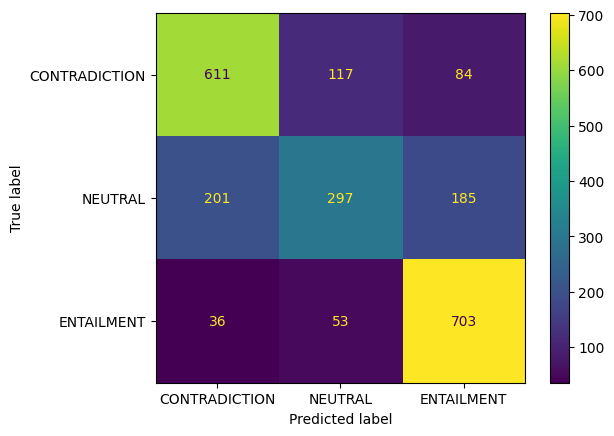

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=['CONTRADICTION', 'NEUTRAL','ENTAILMENT' ])
disp.plot()

# Se stai lavorando in un ambiente interattivo come Jupyter Notebook, la matrice verrà visualizzata automaticamente
# Se sei in uno script Python, puoi usare plt.show() per visualizzare la matrice

plt.show()

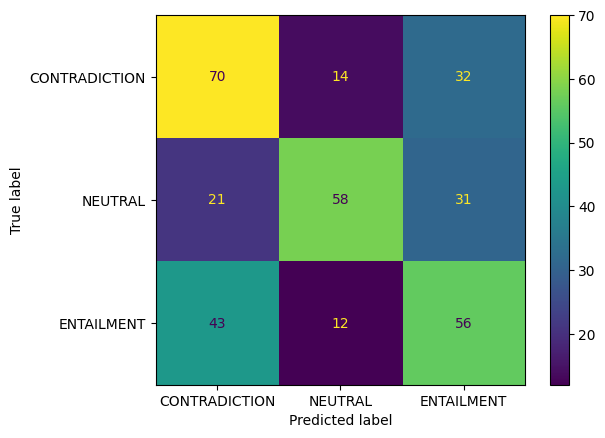

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=['CONTRADICTION', 'NEUTRAL','ENTAILMENT' ])
disp.plot()

plt.show()

In [ ]:
# del training_set

# dataset = NLIDataset(validation_set)


# dataloader = dataset.get_dataloader(batch_size=32, pos_num=1)

# model = RobertaClassifier()

# batch = next(iter(dataloader))

# model(batch[0], batch[1], batch[3])